# Logistics

- Project
    - Student: Isiah Cruz
    - Date: October 28, 2020
    - Module 4 Project


- Summary
    - Contributors evaluated tweets about multiple brands and products. The crowd was asked if the tweet expressed positive, negative, or no emotion towards a brand and/or product. If some emotion was expressed they were also asked to say which brand or product was the target of that emotion


- Task
    - Build a model that can rate the sentiment of a Tweet based on its content.


- Aim for a Proof of Concept
    - There are many approaches to NLP problems - start with something simple and iterate from there. For example, you could start by limiting your analysis to positive and negative Tweets only, allowing you to build a binary classifier. Then you could add in the neutral Tweets to build out a multiclass classifier. You may also consider using some of the more advanced NLP methods in the Mod 4 Appendix.
    
    
- Evaluation
    - Evaluating multiclass classifiers can be trickier than binary classifiers because there are multiple ways to mis-classify an observation, and some errors are more problematic than others. Use the business problem that your NLP project sets out to solve to inform your choice of evaluation metrics.
    
    
- Dataset
    - https://data.world/crowdflower/brands-and-product-emotions

# Importing

In [22]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk 
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_curve, auc, confusion_matrix
from sklearn.metrics import r2_score, roc_auc_score, recall_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import seaborn as sns
import re
from wordcloud import WordCloud

In [2]:
#import the original dataset
df = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding = 'unicode_escape')

# Data Cleaning

In [3]:
#rename the columns to make referencing them easier
df = df.rename(columns={'tweet_text': 'tweet', 'emotion_in_tweet_is_directed_at': 'Brand',
'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'})

In [4]:
df.sentiment = df.sentiment.map(lambda x: 'Positive' if x == 'Positive emotion' else 'Negative' if x == 'Negative emotion' else 'Neutral')

In [5]:
df = df.drop('Brand', 1)

In [6]:
df['sentiment'].value_counts()

Neutral     5545
Positive    2978
Negative     570
Name: sentiment, dtype: int64

## Null Values / De-duplication

In [7]:
df.isna().sum()
df.dropna(inplace=True)
df.isna().sum()

tweet        0
sentiment    0
dtype: int64

In [8]:
dups = df['tweet'].duplicated()
print(dups.value_counts())

False    9065
True       27
Name: tweet, dtype: int64


In [9]:
df = df.drop_duplicates()
df.shape

(9070, 2)

In [10]:
df.head(n=5)

,tweet,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive
3,@sxsw I hope this year's festival isn't as cra...,Negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive


## Stopwords

In [11]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [12]:
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [13]:
stop_words.extend(['link', 'quot'])

In [14]:
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [15]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [16]:
df.tweet = df.tweet.apply(lambda x: preprocess(x))

In [17]:
df.head(n=5)

,tweet,sentiment
0,wesley83 3g iphone 3 hrs tweeting rise austin ...,Negative
1,know fludapp awesome ipad iphone app likely ap...,Positive
2,wait ipad 2 also sale sxsw,Positive
3,hope year festival crashy year iphone app sxsw,Negative
4,great stuff fri sxsw marissa mayer google tim ...,Positive


# Exploratory Data Analysis

## Sentiment Distribution

Text(0.5, 1.0, 'Sentiment Data Distribution')

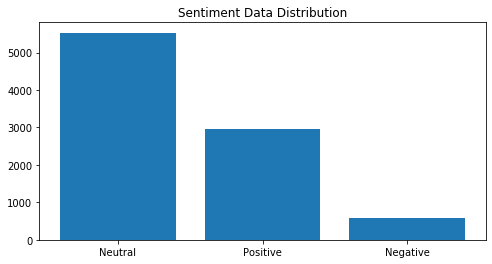

In [23]:
val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

## Word Count

In [24]:
df["word_count"] = df['tweet'].apply(lambda x: len(str(x).split()))

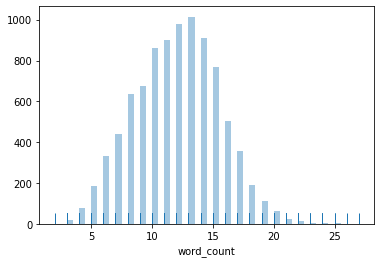

In [25]:
sns.distplot(df.word_count, kde=False, rug=True)

## Word Cloud

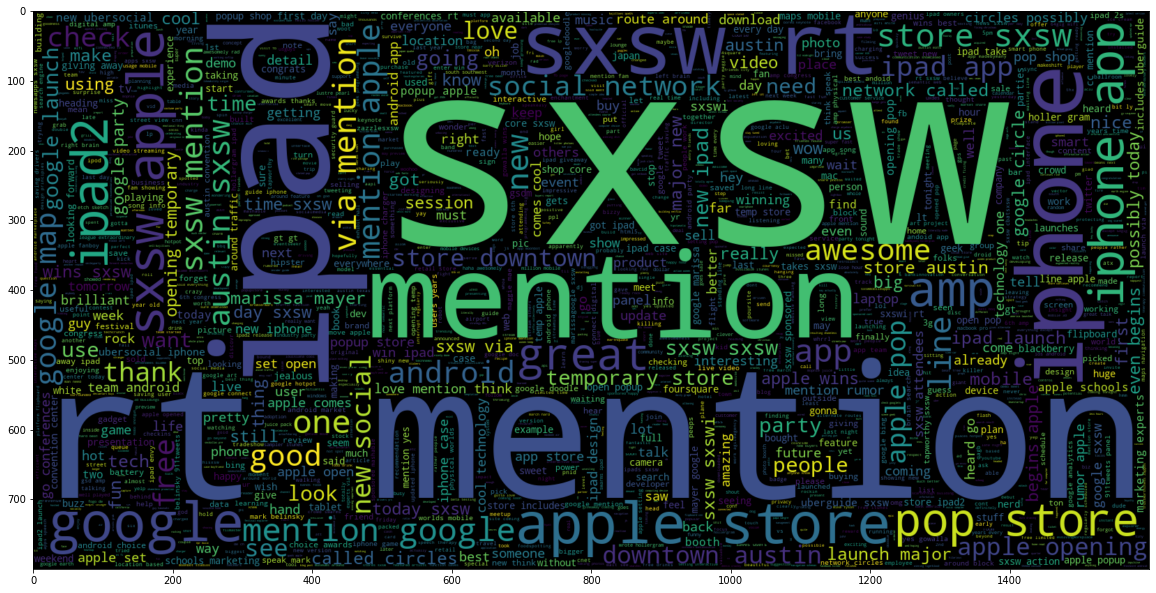

In [26]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Positive'].tweet))
plt.imshow(wc , interpolation = 'bilinear')

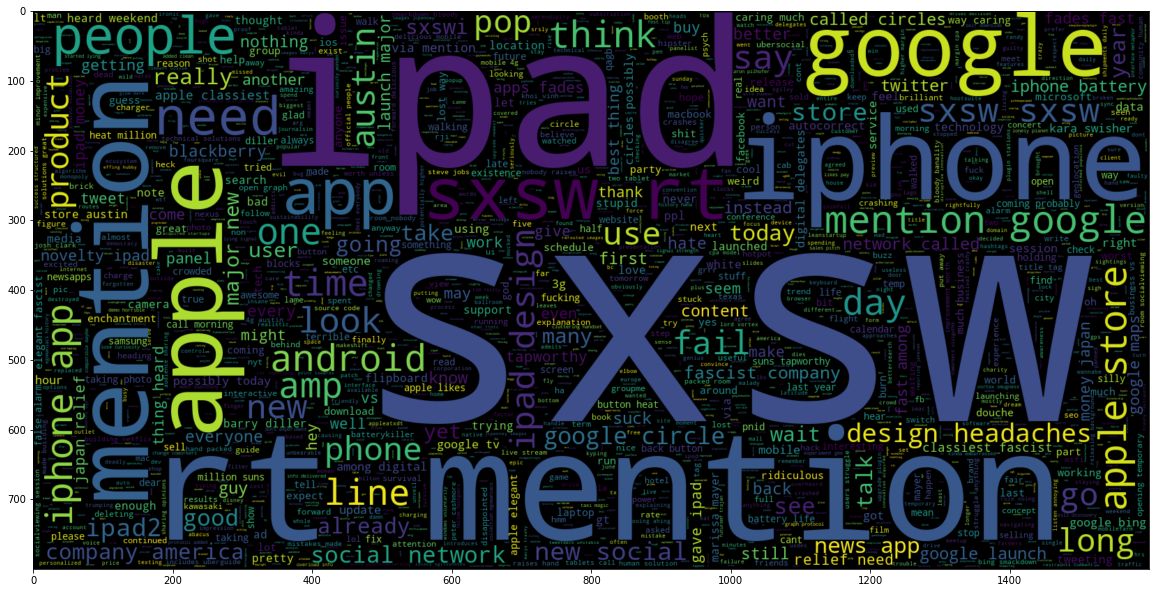

In [27]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Negative'].tweet))
plt.imshow(wc , interpolation = 'bilinear')

# Pre-Processing

In [28]:
# Grabbing our inputs and target
X = df['tweet']
y = df['sentiment']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Label Encoding

In [29]:
encoder = LabelEncoder()
encoder.fit(y_train.to_list())

y_train = encoder.transform(y_train.to_list())
y_test = encoder.transform(y_test.to_list())

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (6802,)
y_test shape: (2268,)


## Count Vectorizer

In [30]:
# Intstantiating our vectorizer
count_vectorizer = CountVectorizer()

# Training on the train set, then transforming the train set
X_count_train = count_vectorizer.fit_transform(X_train)
# Transforming the test set
X_count_test = count_vectorizer.transform(X_test)

In [31]:
X_count_train

<6802x8368 sparse matrix of type '<class 'numpy.int64'>'
	with 74492 stored elements in Compressed Sparse Row format>

In [32]:
X_count_test

<2268x8368 sparse matrix of type '<class 'numpy.int64'>'
	with 23739 stored elements in Compressed Sparse Row format>

In [33]:
# Instantiating a classifier to use on this text - Multinomial Naive Bayes
nb_classifier = MultinomialNB()

# Fitting the classifier
nb_classifier.fit(X_count_train, y_train)

# Getting our predictions for the train and test sets
train_preds = nb_classifier.predict(X_count_train)
test_preds = nb_classifier.predict(X_count_test)

Train Accuracy: 0.8238753307850633
Test Accuracy: 0.6715167548500882


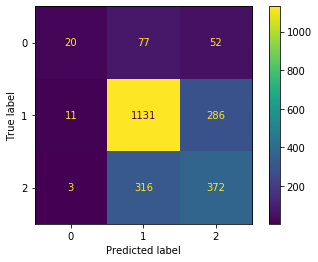

In [34]:
# Let's see how we did!
print(f"Train Accuracy: {accuracy_score(y_train, train_preds)}")
print(f"Test Accuracy: {accuracy_score(y_test, test_preds)}")
plot_confusion_matrix(nb_classifier, X_count_test, y_test, values_format='.4g')

In [35]:
def classify_vectorized_text(vectorizer, classifier, Xtrain, Xtest, ytrain, ytest):

    Xtrain_transformed = vectorizer.fit_transform(Xtrain)
    Xtest_transformed = vectorizer.transform(Xtest)

    classifier.fit(Xtrain_transformed, ytrain)

    train_preds = classifier.predict(Xtrain_transformed)
    test_preds = classifier.predict(Xtest_transformed)

    print(f"Train Accuracy: {accuracy_score(ytrain, train_preds)}")
    print(f"Test Accuracy: {accuracy_score(ytest, test_preds)}")
    plot_confusion_matrix(classifier, Xtest_transformed, ytest,
                          values_format=".4g")  # to make numbers readable
    plt.show()

    return(train_preds, test_preds)

## TFIDF Vectorizer

In [36]:
# Instantiating the TF-IDF vectorizer
tfidf = TfidfVectorizer(stop_words=stopwords.words('english'), 
                        max_df = .95, # removes words that appear in more than 95% of docs
                        min_df = 2, # removes words that appear 2 or fewer times
                        use_idf=True)

# Training on the train set, then transforming the train set
tfidf_train = tfidf.fit_transform(X_train)
# Transforming the test set
tfidf_test = tfidf.transform(X_test)

In [37]:
# Here, number of rows is the length of our train set
tfidf_train

<6802x4521 sparse matrix of type '<class 'numpy.float64'>'
	with 63852 stored elements in Compressed Sparse Row format>

In [38]:
# Here, number of rows is the length of our test set
tfidf_test

<2268x4521 sparse matrix of type '<class 'numpy.float64'>'
	with 20437 stored elements in Compressed Sparse Row format>

In [39]:
tfidf_test_df = pd.DataFrame(tfidf_test.toarray(), columns=tfidf.get_feature_names())

# Modeling

Train Accuracy: 0.7590414583945898
Test Accuracy: 0.6825396825396826


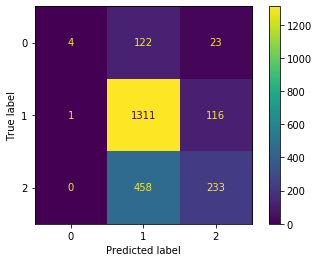

In [40]:
multinomial = MultinomialNB()

# Again, using our function
tfidf_train_preds, tfidf_test_preds = classify_vectorized_text(
    tfidf, multinomial, X_train, X_test, y_train, y_test)

Train Accuracy: 0.9916201117318436
Test Accuracy: 0.6979717813051146


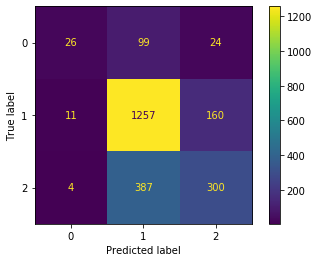

In [41]:
rfc = RandomForestClassifier(n_estimators=100)

rfc_train_preds, rfc_test_preds = classify_vectorized_text(
    tfidf, rfc, X_train, X_test, y_train, y_test)

Train Accuracy: 0.7972655101440753
Test Accuracy: 0.6966490299823633


/Users/cruzisiah/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


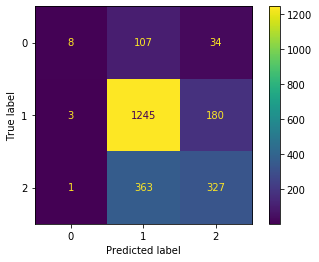

In [42]:
log = LogisticRegression()

log_train_preds, log_test_preds = classify_vectorized_text(
    tfidf, log, X_train, X_test, y_train, y_test)

Train Accuracy: 0.886062922669803
Test Accuracy: 0.7173721340388007


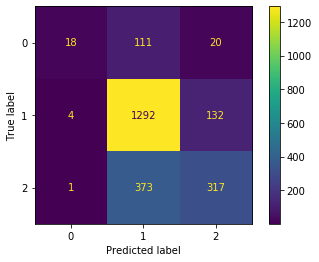

In [43]:
svc = SVC()

svc_train_preds, svc_test_preds = classify_vectorized_text(
    tfidf, svc, X_train, X_test, y_train, y_test)

Train Accuracy: 0.8801822993237283
Test Accuracy: 0.6962081128747796


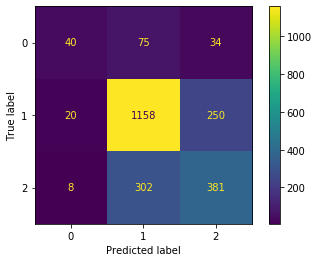

In [44]:
linear_svc = LinearSVC()

linear_svc_train_preds, linear_svc_test_preds = classify_vectorized_text(
    tfidf, linear_svc, X_train, X_test, y_train, y_test)

# Conclusion

## Evaluation

In [45]:
print('BEST MODEL: SVC')
print('ACCURACY: 0.711')

BEST MODEL: SVC
ACCURACY: 0.711


## Recommendations & Future Work

- Our SVC model can sort tweets as positive, neutral, or negative with a high degree of accuracy - 71%.
- **Next Step #1:** The most logical next step will be to run this model on our current dataset as an improvement upon the human-sorted classification.
- **Next Step #2:** For future SXSW and similar events, we will also be able to deploy this model to detect consumer/brand sentiment in real-time!